In [2]:
import cython
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pymc3 as pm
import pandas as pd

from lib.car_model import CAR2
from lib.utils import pad, new_name, create_matrices, get_digit_indices
from matplotlib.image import imread

from theano import scan
import theano.tensor as tt

from pymc3.distributions import continuous
from pymc3.distributions import distribution

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

In [30]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
d = x_train[12].copy()
x_train = x_train/255
x_test  = x_test/255

def subset(label, data=x_train, labels=y_train):
    '''
    e.g. subset(3) -> gets all pictures of digit 3
    '''
    assert label >= 0 and label <= 9
    
    return data[np.argwhere(labels == 3)]

In [4]:
def plot(image, figsize=(16, 7)):
    
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='Greys')
    
def plot_many():
    for i in range(10):
        get_digit_indices(y_train, i, 10)

In [31]:
d = d.reshape(-1,) # type int
[np.percentile(d, q) for q in [0, 25, 50, 75, 100]]

[0.0, 0.0, 0.0, 6.25, 255.0]

In [35]:
print(sum([pixel == 0 for pixel in d]))
print(sum([pixel == 1 for pixel in d]))
print(sum([pixel == 254 for pixel in d]))
print(sum([pixel == 255 for pixel in d]))
print(sum([pixel == 256 for pixel in d]))

583
0
79
1
0


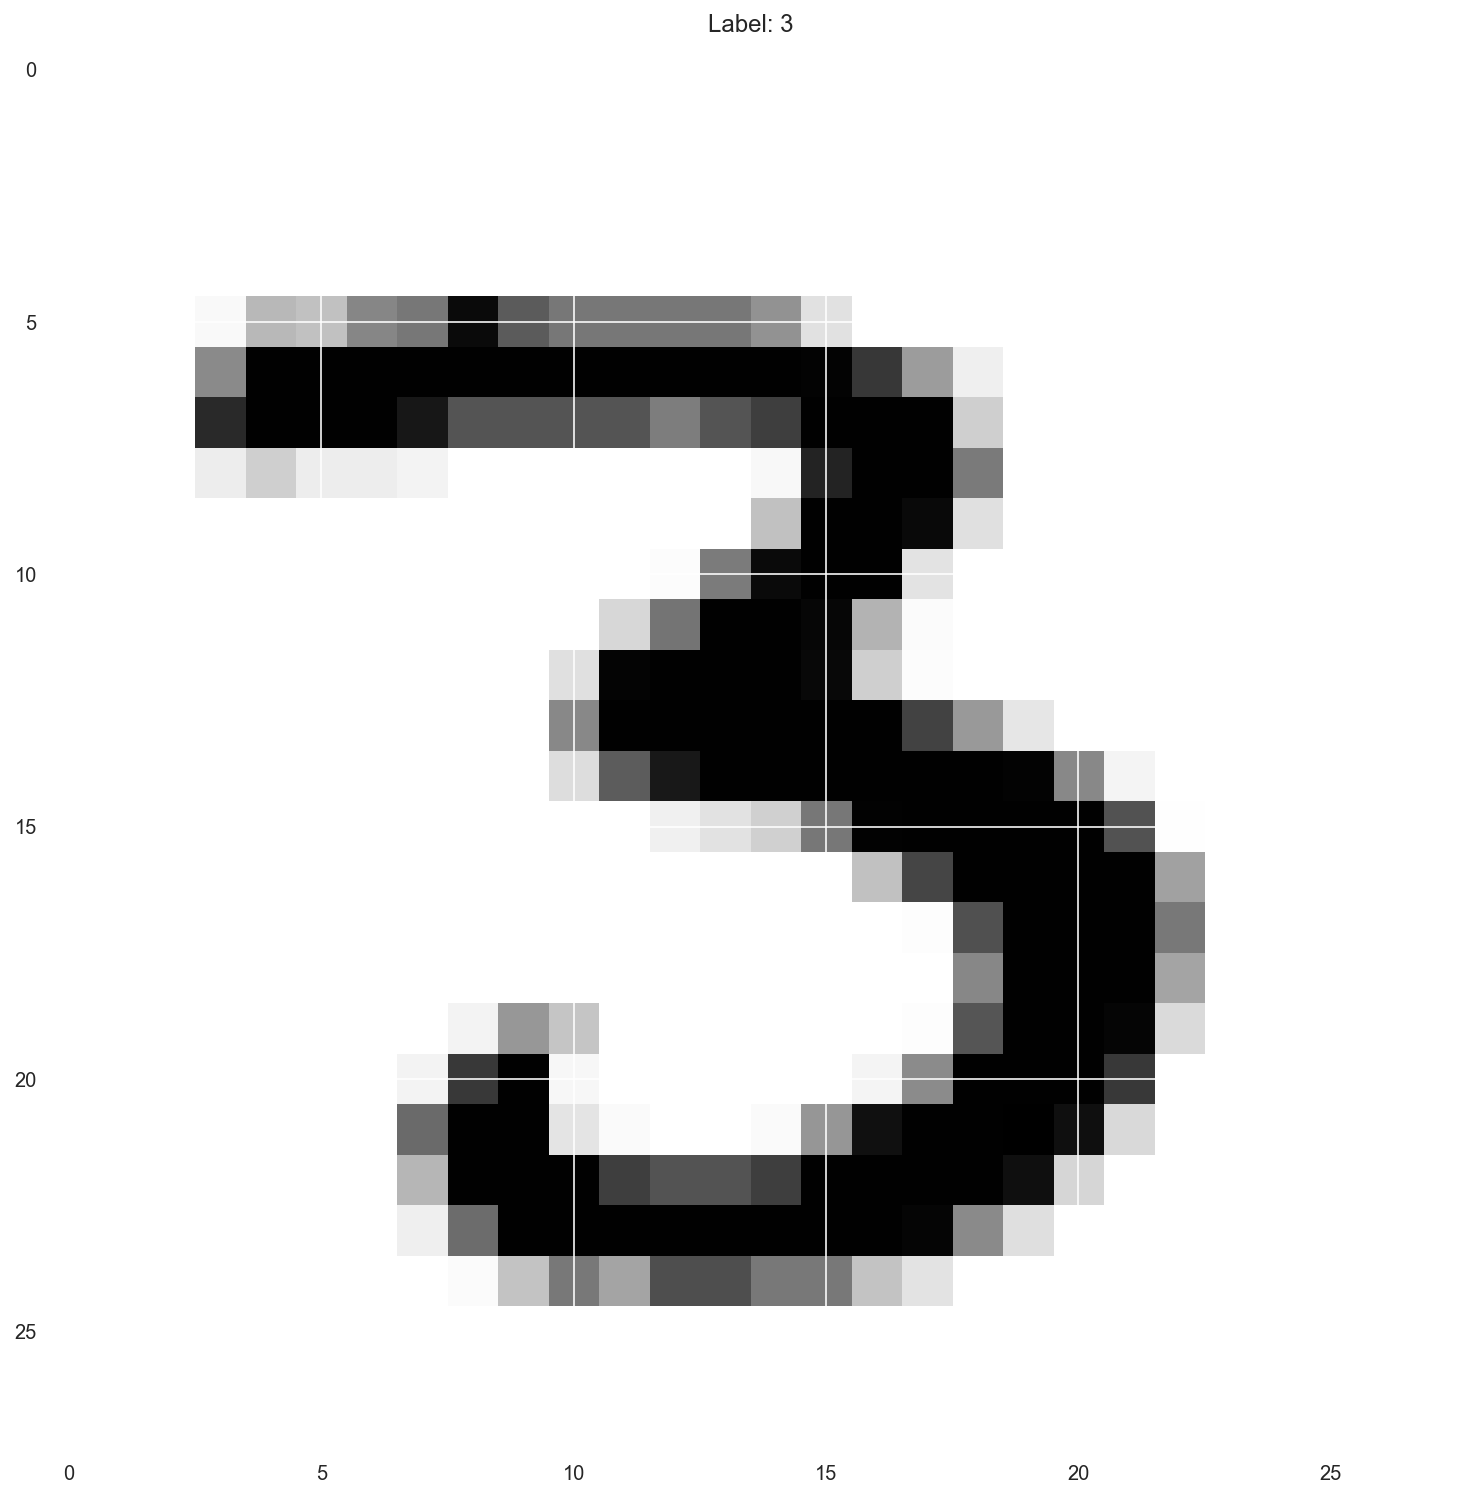

In [5]:
dummy = x_train[12]
plot(dummy, figsize=(20, 13))
_ = plt.title('Label: ' + str(y_train[12]))

In [7]:
pd.DataFrame(dummy).to_csv('images/handwritten_digit.csv', index=False, header=False)

In [8]:
O = np.concatenate(dummy)

Taken from https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

In [9]:
adj = []
position_matrix = np.linspace(0, 28*28 - 1, num=28*28).astype(np.int64).reshape(28, 28)
count = 0

for i, row in enumerate(position_matrix):
    for j, col in enumerate(position_matrix[i]):
        assert position_matrix[i][j] == col
        
        temp = []

        # change these loops if we do not want to
        # include diagonal elements in adj matrix
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                if ((i + delta_i) // 28 == 0) and ((j + delta_j) // 28 == 0):    
                    temp.append(position_matrix[i + delta_i][j + delta_j])
        

        temp.remove(col)
        temp.sort()
        adj.append(temp)
        
weights = [list(np.ones_like(adj_elems).astype(np.int64)) for adj_elems in adj]

# below is taken from the pymc3 CAR tutorial website
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

In [10]:
adj

[[1, 28, 29],
 [0, 2, 28, 29, 30],
 [1, 3, 29, 30, 31],
 [2, 4, 30, 31, 32],
 [3, 5, 31, 32, 33],
 [4, 6, 32, 33, 34],
 [5, 7, 33, 34, 35],
 [6, 8, 34, 35, 36],
 [7, 9, 35, 36, 37],
 [8, 10, 36, 37, 38],
 [9, 11, 37, 38, 39],
 [10, 12, 38, 39, 40],
 [11, 13, 39, 40, 41],
 [12, 14, 40, 41, 42],
 [13, 15, 41, 42, 43],
 [14, 16, 42, 43, 44],
 [15, 17, 43, 44, 45],
 [16, 18, 44, 45, 46],
 [17, 19, 45, 46, 47],
 [18, 20, 46, 47, 48],
 [19, 21, 47, 48, 49],
 [20, 22, 48, 49, 50],
 [21, 23, 49, 50, 51],
 [22, 24, 50, 51, 52],
 [23, 25, 51, 52, 53],
 [24, 26, 52, 53, 54],
 [25, 27, 53, 54, 55],
 [26, 54, 55],
 [0, 1, 29, 56, 57],
 [0, 1, 2, 28, 30, 56, 57, 58],
 [1, 2, 3, 29, 31, 57, 58, 59],
 [2, 3, 4, 30, 32, 58, 59, 60],
 [3, 4, 5, 31, 33, 59, 60, 61],
 [4, 5, 6, 32, 34, 60, 61, 62],
 [5, 6, 7, 33, 35, 61, 62, 63],
 [6, 7, 8, 34, 36, 62, 63, 64],
 [7, 8, 9, 35, 37, 63, 64, 65],
 [8, 9, 10, 36, 38, 64, 65, 66],
 [9, 10, 11, 37, 39, 65, 66, 67],
 [10, 11, 12, 38, 40, 66, 67, 68],
 [11, 12, 13

In [11]:
with pm.Model() as model:
    beta0  = pm.Normal('beta0', mu=0., tau=1e-2)
    tau    = pm.Gamma('tau_c', alpha=1.0, beta=1.0)
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau, shape=N)
    phi    = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi)) # zero-center phi
    
    
    mu = pm.Deterministic('mu', beta0 + phi)
    Yi = pm.LogitNormal('Yi', mu=mu, observed=pad(O))
    
    trace = pm.sample(draws=1000, chains=2)
    #trace = pm.sample(draws=2000, step=pm.Metropolis())
    posterior_pred = pm.sample_posterior_predictive(trace)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a3735f7c57bf>", line 3, in <module>
    tau    = pm.Gamma('tau_c', alpha=1.0, beta=1.0)
  File "/anaconda3/envs/ml/lib/python3.6/site-packages/pymc3/distributions/distribution.py", line 42, in __new__
    return model.Var(name, dist, data, total_size)
  File "/anaconda3/envs/ml/lib/python3.6/site-packages/pymc3/model.py", line 816, in Var
    model=self)
  File "/anaconda3/envs/ml/lib/python3.6/site-packages/pymc3/model.py", line 1492, in __init__
    transformed_name, transform.apply(distribution), total_size=total_size)
  File "/anaconda3/envs/ml/lib/python3.6/site-packages/pymc3/distributions/transforms.py", line 95, in apply
    return TransformedDistribution.dist(dist, self)
  File "/anaconda3/envs/ml/lib/python3.6/site-packages/pymc3/distributions/distribu

KeyboardInterrupt: 

Check average proportion of pixels equal to 0 and 1 (or near 1, i.e. 253 or 254)

In [ ]:
_ = pm.traceplot(trace, varnames=['beta0', 'tau_c'])

In [ ]:
plot(np.mean(trace.get_values('phi'), axis=0).reshape(28, 28))

In [ ]:
plot(np.std(trace.get_values('phi'), axis=0).reshape(28, 28))

In [ ]:
_ = plt.hist(x_train[12].reshape(-1), bins=15)

### Trying breast cancer image

In [ ]:
image = imread('images/malignant_R_MLO.jpg')
image = image[:, :, 0]
image = np.max(image) - image
x_dim, y_dim = image.shape

In [ ]:
print(image.shape)

In [ ]:
plt.imshow(image)

In [ ]:
adj = []
position_matrix = np.linspace(0, x_dim*y_dim - 1, num=x_dim*y_dim).astype(np.int64).reshape(x_dim, y_dim)
count = 0

for i, row in enumerate(position_matrix):
    for j, col in enumerate(position_matrix[i]):
        assert position_matrix[i][j] == col
        
        temp = []

        # change these loops if we do not want to
        # include diagonal elements in adj matrix
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                if ((i + delta_i) // x_dim == 0) and ((j + delta_j) // y_dim == 0):    
                    temp.append(position_matrix[i + delta_i][j + delta_j])
        

        temp.remove(col)
        temp.sort()
        adj.append(temp)
        
weights = [list(np.ones_like(adj_elems).astype(np.int64)) for adj_elems in adj]

# below is taken from the pymc3 CAR tutorial website
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat = np.zeros((N, N))
amat = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat[i, a] = 1
    wmat[i, a] = weights[i]

In [ ]:

np.zeros((N, N))

In [ ]:
with pm.Model() as a:
    b = pm.Gamma('test', alpha=1, beta=1)

In [ ]:
with pm.Model() as model:
    beta0  = pm.Normal('beta0', mu=0., tau=1e-2)
    tau    = pm.Gamma('tau_c', alpha=1.0, beta=1.0)
    mu_phi = CAR2('mu_phi', w=wmat, a=amat, tau=tau, shape=N)
    phi    = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi)) # zero-center phi
    
    
    mu = pm.Deterministic('mu', beta0 + phi)
    Yi = pm.LogitNormal('Yi', mu=mu, observed=pad(O))
    
    trace = pm.sample(draws=1000, chains=2)
    #trace = pm.sample(draws=2000, step=pm.Metropolis())
    posterior_pred = pm.sample_posterior_predictive(trace)

In [ ]:
new_name(name='phi_values', suffix='.npy', directory='results/')

# Exact sparse CAR models in Stan


[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.210407.svg)](https://doi.org/10.5281/zenodo.210407)



Max Joseph  
August 20, 2016  


This document details sparse exact conditional autoregressive (CAR) models in Stan as an extension of previous work on approximate sparse CAR models in Stan. 
Sparse representations seem to give order of magnitude efficiency gains, scaling better for large spatial data sets. 

## CAR priors for spatial random effects

Conditional autoregressive (CAR) models are popular as prior distributions for spatial random effects with areal spatial data. 
If we have a random quantity $\phi = (\phi_1, \phi_2, ..., \phi_n)'$ at $n$ areal locations, the CAR model is often expressed via full conditional distributions:

$$\phi_i \mid \phi_j, j \neq i \sim N(\alpha \sum_{j = 1}^n b_{ij} \phi_j, \tau_i^{-1})$$

where $\tau_i$ is a spatially varying precision parameter, and $b_{ii} = 0$. 

By Brook's Lemma, the joint distribution of $\phi$ is then:

$$\phi \sim N(0, [D_\tau (I - \alpha B)]^{-1}).$$

If we assume the following:

- $D_\tau = \tau D$
- $D = diag(m_i)$: an $n \times n$ diagonal matrix with $m_i$ = the number of neighbors for location $i$
- $I$: an $n \times n$ identity matrix
- $\alpha$: a parameter that controls spatial dependence ($\alpha = 0$ implies spatial independence, and $\alpha = 1$ collapses to an *intrisnic conditional autoregressive* (IAR) specification)
- $B = D^{-1} W$: the scaled adjacency matrix
- $W$: the adjacency matrix ($w_{ii} = 0, w_{ij} = 1$ if $i$ is a neighbor of $j$, and $w_{ij}=0$ otherwise)

then the CAR prior specification simplifies to: 

$$\phi \sim N(0, [\tau (D - \alpha W)]^{-1}).$$

The $\alpha$ parameter ensures propriety of the joint distrbution of $\phi$ as long as $| \alpha | < 1$ (Gelfand & Vounatsou 2003).
However, $\alpha$ is often taken as 1, leading to the IAR specification which creates a singular precision matrix and an improper prior distribution.

## A Poisson specification

Suppose we have aggregated count data $y_1, y_2, ..., y_n$ at $n$ locations, and we expect that neighboring locations will have similar counts. 
With a Poisson likelihood: 

$$y_i \sim \text{Poisson}(\text{exp}(X_{i} \beta + \phi_i + \log(\text{offset}_i)))$$

where $X_i$ is a design vector (the $i^{th}$ row from a design matrix), $\beta$ is a vector of coefficients, $\phi_i$ is a spatial adjustment, and $\log(\text{offset}_i)$ accounts for differences in expected values or exposures at the spatial units (popular choices include area for physical processes, or population size for disease applications). 

If we specify a proper CAR prior for $\phi$, then we have that $\phi \sim \text{N}(0, [\tau (D - \alpha W)]^{-1})$ where $\tau (D - \alpha W)$ is the precision matrix $\Sigma^{-1}$.
A complete Bayesian specification would include priors for the remaining parameters $\alpha$, $\tau$, and $\beta$, such that our posterior distribution is: 

$$p(\phi, \beta, \alpha, \tau \mid y) \propto p(y \mid \beta, \phi) p(\phi \mid \alpha, \tau) p(\alpha) p(\tau) p(\beta)$$

## Example: Scottish lip cancer data

To demonstrate this approach we'll use the Scottish lip cancer data example (some documentation [here](https://cran.r-project.org/web/packages/CARBayesdata/CARBayesdata.pdf)). 
This data set includes observed lip cancer case counts at 56 spatial units in Scotland, with an expected number of cases to be used as an offset, and an area-specific continuous covariate that represents the proportion of the population employed in agriculture, fishing, or forestry.
The model structure is identical to the Poisson model outlined above. 


```
## Warning in gpclibPermit(): support for gpclib will be withdrawn from
## maptools at the next major release
```

```
## [1] TRUE
```

![](README_files/figure-html/make-scotland-map-1.png)<!-- -->

Let's start by loading packages and data, specifying the number of MCMC iterations and chains.


```r
library(ggmcmc)
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
source('data/scotland_lip_cancer.RData')

# Define MCMC parameters 
niter <- 1E4   # definitely overkill, but good for comparison
nchains <- 4
```

To fit the full model, we'll pull objects loaded with our Scotland lip cancer data. 
I'll use `model.matrix` to generate a design matrix, centering and scaling the continuous covariate `x` to reduce correlation between the intercept and slope estimates. 


```r
W <- A # adjacency matrix
scaled_x <- c(scale(x))
X <- model.matrix(~scaled_x)
  
full_d <- list(n = nrow(X),         # number of observations
               p = ncol(X),         # number of coefficients
               X = X,               # design matrix
               y = O,               # observed number of cases
               log_offset = log(E), # log(expected) num. cases
               W = W)               # adjacency matrix
```

#### Stan implementation: CAR with `multi_normal_prec`

Our model statement mirrors the structure outlined above, with explicit normal and gamma priors on $\beta$ and $\tau$ respectively, and a $\text{Uniform}(0, 1)$ prior for $\alpha$. 
The prior on $\phi$ is specified via the `multi_normal_prec` function, passing in $\tau (D - \alpha W)$ as the precision matrix.


```
data {
  int<lower = 1> n;
  int<lower = 1> p;
  matrix[n, p] X;
  int<lower = 0> y[n];
  vector[n] log_offset;
  matrix<lower = 0, upper = 1>[n, n] W;
}
transformed data{
  vector[n] zeros;
  matrix<lower = 0>[n, n] D;
  {
    vector[n] W_rowsums;
    for (i in 1:n) {
      W_rowsums[i] = sum(W[i, ]);
    }
    D = diag_matrix(W_rowsums);
  }
  zeros = rep_vector(0, n);
}
parameters {
  vector[p] beta;
  vector[n] phi;
  real<lower = 0> tau;
  real<lower = 0, upper = 1> alpha;
}
model {
  phi ~ multi_normal_prec(zeros, tau * (D - alpha * W));
  beta ~ normal(0, 1);
  tau ~ gamma(2, 2);
  y ~ poisson_log(X * beta + phi + log_offset);
}
```

Fitting the model with `rstan`:


```r
full_fit <- stan('stan/car_prec.stan', data = full_d, 
                 iter = niter, chains = nchains, verbose = FALSE)
print(full_fit, pars = c('beta', 'tau', 'alpha', 'lp__'))
```

```
## Inference for Stan model: car_prec.
## 4 chains, each with iter=10000; warmup=5000; thin=1; 
## post-warmup draws per chain=5000, total post-warmup draws=20000.
## 
##           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
## beta[1]   0.02    0.02 0.29  -0.52  -0.15   0.00   0.16   0.69   321 1.01
## beta[2]   0.27    0.00 0.09   0.08   0.21   0.27   0.34   0.45  3981 1.00
## tau       1.65    0.01 0.50   0.85   1.29   1.59   1.93   2.83  6218 1.00
## alpha     0.93    0.00 0.06   0.77   0.91   0.95   0.98   1.00  3804 1.00
## lp__    820.81    0.10 6.73 806.63 816.45 821.18 825.52 832.99  4485 1.00
## 
## Samples were drawn using NUTS(diag_e) at Thu Feb  9 18:25:48 2017.
## For each parameter, n_eff is a crude measure of effective sample size,
## and Rhat is the potential scale reduction factor on split chains (at 
## convergence, Rhat=1).
```

```r
# visualize results 
to_plot <- c('beta', 'tau', 'alpha', 'phi[1]', 'phi[2]', 'phi[3]', 'lp__')
traceplot(full_fit, pars = to_plot)
```

![](README_files/figure-html/fit-prec-model-1.png)<!-- -->

### A more efficient sparse representation

Although we could specify our multivariate normal prior for $\phi$ directly in Stan via `multi_normal_prec`, as we did above, in this case we will accrue computational efficiency gains by manually specifying $p(\phi \mid \tau, \alpha)$ directly via the log probability accumulator. 
The log probability of $\phi$ is: 

$$\log(p(\phi \mid \tau, \alpha)) = - \frac{n}{2} \log(2 \pi) + \frac{1}{2} \log(\text{det}( \Sigma^{-1})) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

In Stan, we only need the log posterior up to an additive constant so we can drop the first term. 
Then, substituting  $\tau (D - \alpha W)$ for $\Sigma^{-1}$:

$$\frac{1}{2} \log(\text{det}(\tau (D - \alpha W))) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

$$ = \frac{1}{2} \log(\tau ^ n \text{det}(D - \alpha W)) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

$$ = \frac{n}{2} \log(\tau) + \frac{1}{2} \log(\text{det}(D - \alpha W)) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

There are two ways that we can accrue computational efficiency gains: 

1. Sparse representations of $\Sigma^{-1}$ to expedite computation of $\phi^T \Sigma^{-1} \phi$ (this work was done by Kyle foreman previously, e.g., https://groups.google.com/d/topic/stan-users/M7T7EIlyhoo/discussion). 

2. Efficient computation of the determinant. Jin, Carlin, and Banerjee (2005) show that:

$$\text{det}(D - \alpha W) \propto \prod_{i = 1}^n (1 - \alpha \lambda_i)$$

where $\lambda_1, ..., \lambda_n$ are the eigenvalues of $D^{-\frac{1}{2}} W D^{-\frac{1}{2}}$, which can be computed ahead of time and passed in as data. 
Because we only need the log posterior up to an additive constant, we can use this result which is proportional up to some multiplicative constant $c$: 

$$\frac{n}{2} \log(\tau) + \frac{1}{2} \log(c \prod_{i = 1}^n (1 - \alpha \lambda_i)) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

$$= \frac{n}{2} \log(\tau) + \frac{1}{2} \log(c) +  \frac{1}{2} \log(\prod_{i = 1}^n (1 - \alpha \lambda_i)) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

Again dropping additive constants: 

$$\frac{n}{2} \log(\tau) + \frac{1}{2} \log(\prod_{i = 1}^n (1 - \alpha \lambda_i)) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

$$= \frac{n}{2} \log(\tau) + \frac{1}{2} \sum_{i = 1}^n \log(1 - \alpha \lambda_i) - \frac{1}{2} \phi^T \Sigma^{-1} \phi$$

### Stan implementation: sparse CAR

In the Stan model statement's `transformed data` block, we compute $\lambda_1, ..., \lambda_n$ (the eigenvalues of $D^{-\frac{1}{2}} W D^{-\frac{1}{2}}$), and generate a sparse representation for W (`Wsparse`), which is assumed to be symmetric, such that the adjacency relationships can be represented in a two column matrix where each row is an adjacency relationship between two sites. 

The Stan model statement for the sparse implementation never constructs the precision matrix, and does not call any of the `multi_normal*` functions. 
Instead, we use define a `sparse_car_lpdf()` function and use it in the model block. 


```
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(alpha * lambda[i]);
      return 0.5 * (n * log(tau)
                    + sum(ldet_terms)
                    - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}
data {
  int<lower = 1> n;
  int<lower = 1> p;
  matrix[n, p] X;
  int<lower = 0> y[n];
  vector[n] log_offset;
  matrix<lower = 0, upper = 1>[n, n] W; // adjacency matrix
  int W_n;                // number of adjacent region pairs
}
transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[n] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[n] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:n) D_sparse[i] = sum(W[i]);
  {
    vector[n] invsqrtD;  
    for (i in 1:n) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}
parameters {
  vector[p] beta;
  vector[n] phi;
  real<lower = 0> tau;
  real<lower = 0, upper = 1> alpha;
}
model {
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, n, W_n);
  beta ~ normal(0, 1);
  tau ~ gamma(2, 2);
  y ~ poisson_log(X * beta + phi + log_offset);
}
```

Fitting the model:


```r
sp_d <- list(n = nrow(X),         # number of observations
             p = ncol(X),         # number of coefficients
             X = X,               # design matrix
             y = O,               # observed number of cases
             log_offset = log(E), # log(expected) num. cases
             W_n = sum(W) / 2,    # number of neighbor pairs
             W = W)               # adjacency matrix

sp_fit <- stan('stan/car_sparse.stan', data = sp_d, 
               iter = niter, chains = nchains, verbose = FALSE)

print(sp_fit, pars = c('beta', 'tau', 'alpha', 'lp__'))
```

```
## Inference for Stan model: car_sparse.
## 4 chains, each with iter=10000; warmup=5000; thin=1; 
## post-warmup draws per chain=5000, total post-warmup draws=20000.
## 
##           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
## beta[1]  -0.01    0.02 0.29  -0.63  -0.15   0.00   0.15   0.57   140 1.03
## beta[2]   0.27    0.00 0.09   0.09   0.21   0.27   0.34   0.46  4449 1.00
## tau       1.64    0.01 0.50   0.86   1.29   1.58   1.94   2.79  5808 1.00
## alpha     0.93    0.00 0.06   0.76   0.91   0.95   0.97   0.99  3169 1.00
## lp__    782.96    0.10 6.83 768.65 778.50 783.31 787.71 795.26  4418 1.00
## 
## Samples were drawn using NUTS(diag_e) at Thu Feb  9 18:26:06 2017.
## For each parameter, n_eff is a crude measure of effective sample size,
## and Rhat is the potential scale reduction factor on split chains (at 
## convergence, Rhat=1).
```

```r
traceplot(sp_fit, pars = to_plot)
```

![](README_files/figure-html/fit-sparse-model-1.png)<!-- -->

### MCMC Efficiency comparison
 
The main quantity of interest is the effective number of samples per unit time. 
Sparsity gives us an order of magnitude or so gains, mostly via reductions in run time. 


Model     Number of effective samples   Elapsed time (sec)   Effective samples / sec)
-------  ----------------------------  -------------------  -------------------------
full                         4485.084            488.56955                   9.180032
sparse                       4418.415             38.52712                 114.683248

### Posterior distribution comparison

Let's compare the estimates to make sure that we get the same answer with both approaches. 
In this case, I've used more MCMC iterations than we would typically need in to get a better estimate of the tails of each marginal posterior distribution so that we can compare the 95% credible intervals among the two approaches. 

![](README_files/figure-html/compare-parameter-estimates-1.png)<!-- -->



![](README_files/figure-html/unnamed-chunk-1-1.png)<!-- -->

The two approaches give the same answers (more or less, with small differences arising due to MCMC sampling error). 

## Postscript: sparse IAR specification

Although the IAR prior for $\phi$ that results from $\alpha = 1$ is improper, it remains popular (Besag, York, and Mollie, 1991). 
In practice, these models are typically fit with a sum to zero constraints: $\sum_{i\text{ in connected coponent}} \phi_i = 0$ for each connected component of the graph. This allows us to interpret both the overall mean and the component-wise means.

With $\alpha$ fixed to one, we have: 

$$\log(p(\phi \mid \tau)) = - \frac{n}{2} \log(2 \pi) + \frac{1}{2} \log(\text{det}^*(\tau (D - W))) - \frac{1}{2} \phi^T \tau (D - W) \phi$$

$$ = - \frac{n}{2} \log(2 \pi) + \frac{1}{2} \log(\tau^{n-k} \text{det}^*(D - W)) - \frac{1}{2} \phi^T \tau (D - W) \phi$$

$$ = - \frac{n}{2} \log(2 \pi) + \frac{1}{2} \log(\tau^{n-k}) + \frac{1}{2} \log(\text{det}^*(D - W)) - \frac{1}{2} \phi^T \tau (D - W) \phi$$

Here $\text{det}^*(A)$ is the generalized determinant of the square matrix $A$ defined as the product of its non-zero eigenvalues, and $k$ is the number of connected components in the graph. For the Scottish Lip Cancer data, there is only one connected component and $k=1$.  The reason that we need to use the generalized determinant is that the precision matrix is, by definition, singular in intrinsic models as the support of the Gaussian distribution is on a subspace with fewer than $n$ dimensions.  For the classical ICAR(1) model, we know that the directions correpsonding to the zero eigenvalues are exactly the vectors that are constant on each connected component of the graph and hence $k$ is the number of connected components.


Dropping additive constants, the quantity to increment becomes: 

$$ \frac{1}{2} \log(\tau^{n-k}) - \frac{1}{2} \phi^T \tau (D - W) \phi$$

And the corresponding Stan syntax would be:


```
functions {
  /**
  * Return the log probability of a proper intrinsic autoregressive (IAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a IAR prior
  * @param tau Precision parameter for the IAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of IAR prior up to additive constant
  */
  real sparse_iar_lpdf(vector phi, real tau,
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      return 0.5 * ((n-1) * log(tau)
                    - tau * (phit_D * phi - (phit_W * phi)));
  }
}
data {
  int<lower = 1> n;
  int<lower = 1> p;
  matrix[n, p] X;
  int<lower = 0> y[n];
  vector[n] log_offset;
  matrix<lower = 0, upper = 1>[n, n] W; // adjacency matrix
  int W_n;                // number of adjacent region pairs
}
transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[n] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[n] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:n) D_sparse[i] = sum(W[i]);
  {
    vector[n] invsqrtD;  
    for (i in 1:n) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}
parameters {
  vector[p] beta;
  vector[n] phi_unscaled;
  real<lower = 0> tau;
}
transformed parameters {
  vector[n] phi; // brute force centering
  phi = phi_unscaled - mean(phi_unscaled);
}
model {
  phi_unscaled ~ sparse_iar(tau, W_sparse, D_sparse, lambda, n, W_n);
  beta ~ normal(0, 1);
  tau ~ gamma(2, 2);
  y ~ poisson_log(X * beta + phi + log_offset);
}
```

## References

Besag, Julian, Jeremy York, and Annie Mollié. "Bayesian image restoration, with two applications in spatial statistics." Annals of the institute of statistical mathematics 43.1 (1991): 1-20.

Gelfand, Alan E., and Penelope Vounatsou. "Proper multivariate conditional autoregressive models for spatial data analysis." Biostatistics 4.1 (2003): 11-15.

Jin, Xiaoping, Bradley P. Carlin, and Sudipto Banerjee. "Generalized hierarchical multivariate CAR models for areal data." Biometrics 61.4 (2005): 950-961.